# 2020-05-15
## Connecting segmented MS2 spots

Picking up from the last notebook, I can segment MS2 spots in 3D stacks. Now I need to connect segmented spots across time. Let's think about how to do this. It's a similar problem to those faced with nuclei, but there are some differences:

1. Spots can disappear for (multiple) frames, and it would be useful to not just toss anything that disappears for a frame.
2. I connected nuclei by looking for overlap. Because expected jump lengths for spots is larger than their diameter, I obviously can't do this.
3. I need to drag gaussian fit parameters along with the segmentation.
4. Spots are subject to the constraint that they must stay in the same nucleus.
5. In some experiments (diploids, but also potentially post-replication) we can have two spots in a nucleus.

Some solutions:

1. The simplest way to do this is probably to just assign spots explicitly to nuclei. Under the assumption of one spot per nuclues (see 5), a spot in the nucleus at a previous time point is the same spot. Relies on robust nuclear tracking and segmentation but that should be possible.
2. Assign a max jump length (in nm, will need conversions in axial and lateral dimensions)
3. In connecting function, build data structure to store frame-by-frame fit parameters, including dummy entries for frames where spot disappears.
4. Utilize nuclear mask to aid connections.
5. Not sure. One possibility is explicitly detecting 1 vs. 2 spots. The widths from the gaussian fits may do it. I think I'll proceed on the assumption of a single spot and try to handle multiple spots 

In [3]:
# Import public packages.
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy import ndimage as ndi 
# from skimage import filters, measure, segmentation, transform, exposure, img_as_ubyte, feature, morphology
#from skimage import filters, io
from functools import partial
from importlib import reload
from IPython.core.interactiveshell import InteractiveShell
#InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline

In [4]:
# Import my packages.
import sys
sys.path.append('/Users/MStadler/Bioinformatics/Projects/Zelda/Quarantine_analysis/bin')
from imagep import (read_tiff_folder, read_tiff_lattice, viewer, viewer, 
                    segment_embryo, labelmask_apply_morphology, zstack_normalize_mean,
                   peak_local_max_nD, gradient_nD, labelmask_filter_objsize, filter_labelmask,
                   object_circularity, stack_bgsub, segment_nuclei3D_5, lattice_segment_nuclei_5,
                   dog_filter, imfill, segMS2_3dstack)
import imagep as imp
reload(imp);

In [5]:
# Load stack.
stack = read_tiff_lattice(
    '/Users/MStadler/Bioinformatics/Projects/Zelda/Quarantine_analysis/data/20171207_Zldeve_em5_mv2/',
    span=(0,3))

/Users/MStadler/opt/anaconda3/lib/python3.7/site-packages/skimage/external/tifffile/tifffile.py:2135: UserWarning: tags are not ordered by code
  warnings.warn("tags are not ordered by code")


In [6]:
bgsub = stack_bgsub(stack)

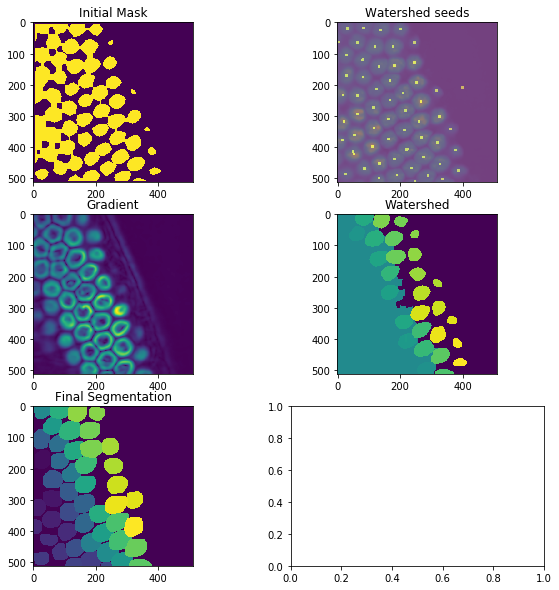

In [58]:
test = segment_nuclei3D_4(bgsub[1,0], seed_window=(70,50,50), circularity_min=5, display=True)

In [13]:
from time import process_time 
t1_start = process_time()  
nucmask = lattice_segment_nuclei_4(bgsub, channel=1, seed_window=(70,40,40))
t1_end = process_time()
print(t1_end - t1_start)

1
2
3


In [15]:
viewer(nucmask, 'tzxy')

interactive(children=(Dropdown(description='Color', index=1, options=('prism', 'viridis', 'gray_r', 'magma', '…

In [28]:
stack2 = read_tiff_lattice(
    '/Users/MStadler/Bioinformatics/Projects/Zelda/Quarantine_analysis/data/20171207_Zldeve_em1_mv2/',
    span=(15,18))

In [30]:
bgsub2 = stack_bgsub(stack2)

booya


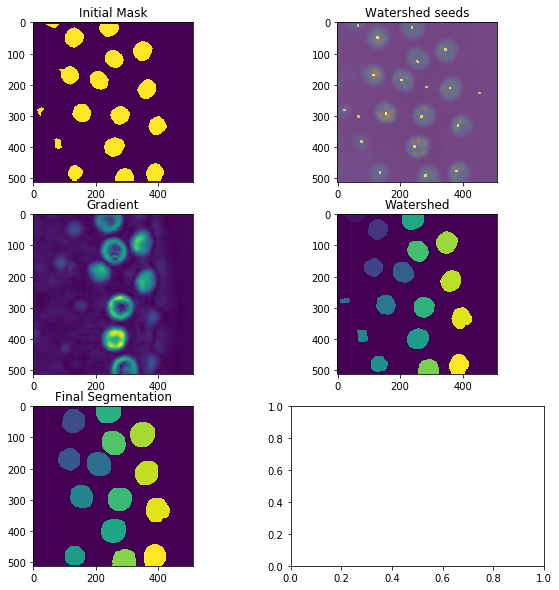

In [56]:
test = imp.segment_nuclei3D_4(bgsub2[1,0], seed_window=(70,70,70), sigma_grad=5, circularity_min=5, display=True)

I played around with the nuclear segmentation some more. I was getting some dropout from circularity filter, dropped it from 10 to 5 and it helped. In the first stack, above, I'm losing a few nuclear at the watershed step.

In [4]:
bgsub = stack_bgsub(stack)

In [15]:
test = lattice_segment_nuclei_4(bgsub, seed_window=(70,50,50), circularity_min=0.0, size_max=2e6, size_min=0)

/Users/MStadler/Bioinformatics/Projects/Zelda/Quarantine_analysis/bin/imagep.py:781: RuntimeWarning: divide by zero encountered in double_scalars
  circularity = 4 * np.pi * area / (perimeter ** 2)


1
2
3


In [ ]:
test = lattice_segment_nuclei_4(bgsub, seed_window=(70,50,50), circularity_min=0.0, size_max=2e6, size_min=0,sigma_grad=4)

In [17]:
viewer(test)

interactive(children=(Dropdown(description='Color', index=3, options=('magma', 'cividis', 'gray', 'viridis', '…

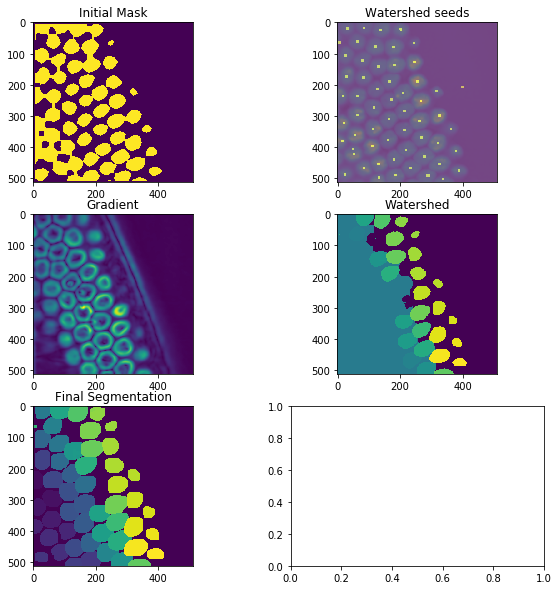

In [19]:
a=segment_nuclei3D_4(bgsub[1,2],seed_window=(70,50,50), circularity_min=0.0, size_max=2e6, size_min=0,display=True)

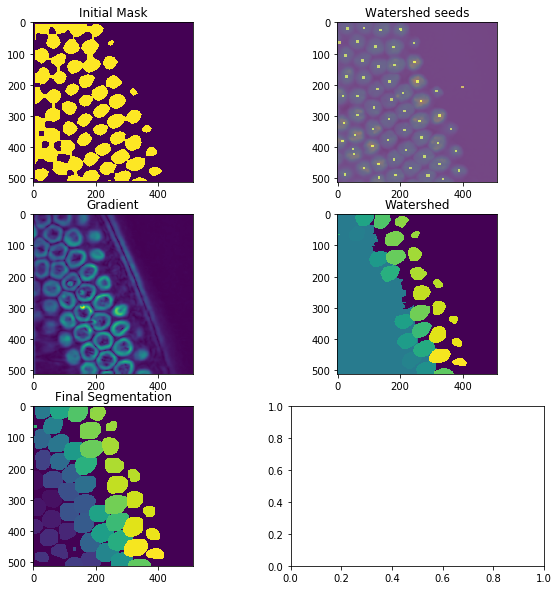

In [20]:
a4=segment_nuclei3D_4(bgsub[1,2],seed_window=(70,50,50), circularity_min=0.0, size_max=2e6, size_min=0,sigma_grad=4,display=True)

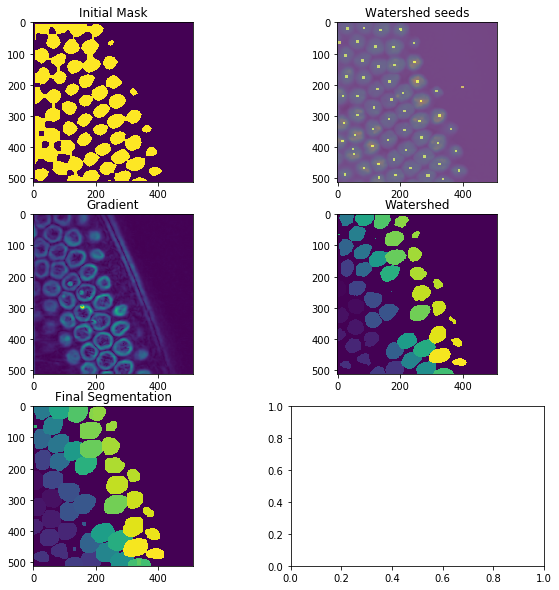

In [21]:
a3=segment_nuclei3D_4(bgsub[1,2],seed_window=(70,50,50), circularity_min=0.0, size_max=2e6, size_min=0,sigma_grad=3,display=True)

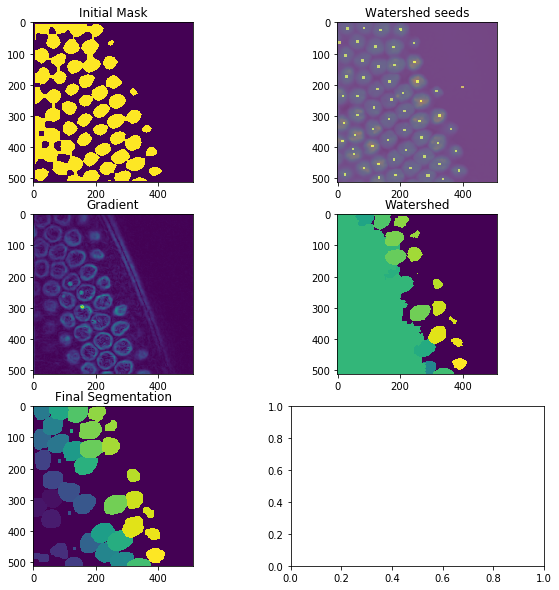

In [22]:
a3=segment_nuclei3D_4(bgsub[1,2],seed_window=(70,50,50), circularity_min=0.0, size_max=2e6, size_min=0,sigma_grad=2,display=True)

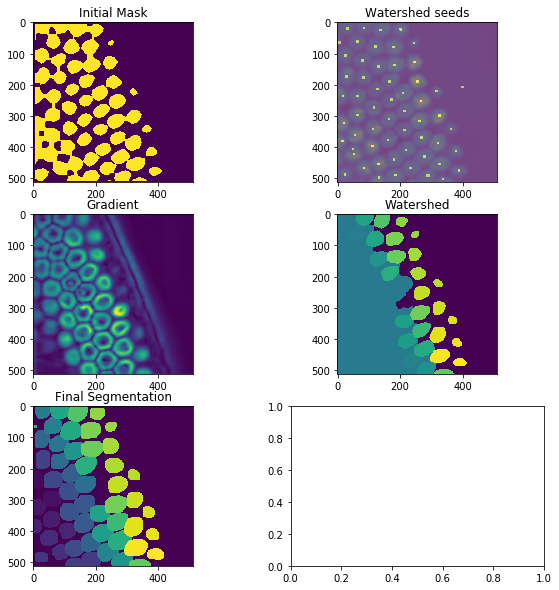

In [23]:
a3=segment_nuclei3D_4(bgsub[1,2],seed_window=(70,50,50), circularity_min=0.0, size_max=2e6, size_min=0,sigma_grad=6,display=True)

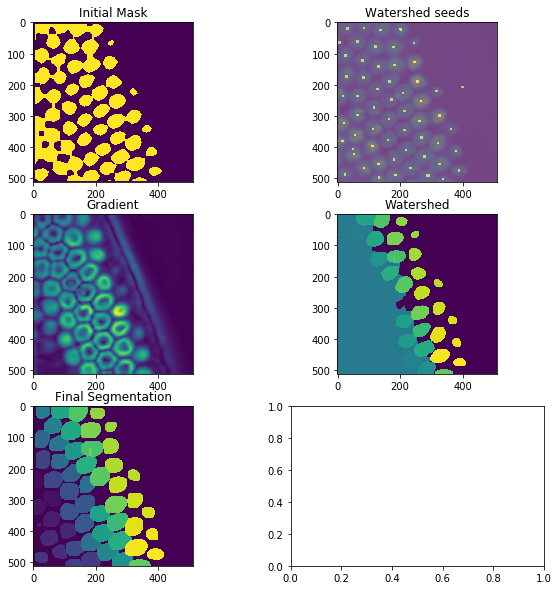

In [24]:
a3=segment_nuclei3D_4(bgsub[1,2],seed_window=(70,50,50), circularity_min=0.0, size_max=2e6, size_min=0,sigma_grad=7,display=True)

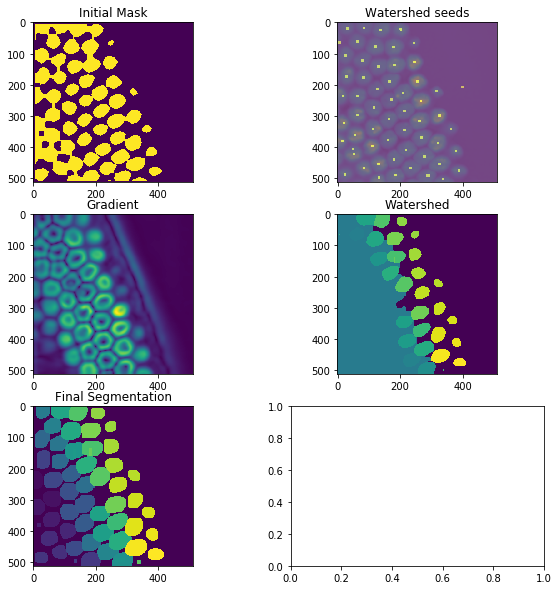

In [25]:
a3=segment_nuclei3D_4(bgsub[1,2],seed_window=(70,50,50), circularity_min=0.0, size_max=2e6, size_min=0,sigma_grad=8,display=True)

So I was losing a few nuclei to dropout, and it was happening at watershed stage. The seeds were good. Only input to that I can modulate (if seeds are good) is the smoothing of the gradient. 

In [26]:
test1 = lattice_segment_nuclei_4(bgsub, seed_window=(70,50,50), circularity_min=0.0, size_max=2e6, size_min=0,sigma_grad=8)

1
2
3


In [28]:
viewer(test1)

interactive(children=(Dropdown(description='Color', index=3, options=('magma', 'cividis', 'gray', 'viridis', '…

Still some dropout. Let's play with sigma1 a little:

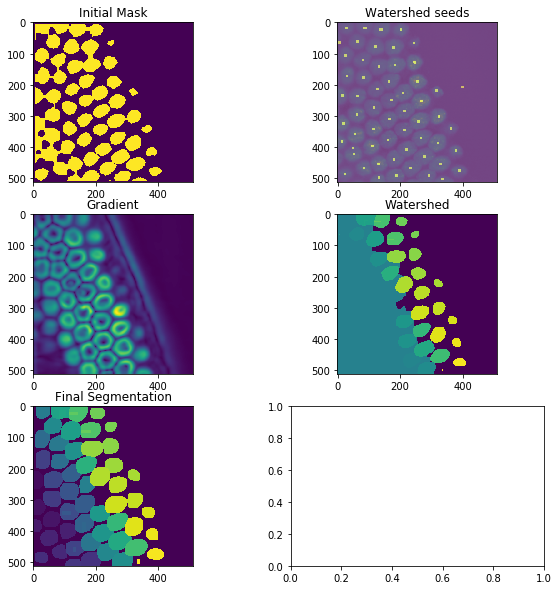

In [29]:
a3=segment_nuclei3D_4(bgsub[1,2],seed_window=(70,50,50), circularity_min=0.0, size_max=2e6, size_min=0,sigma1=1,sigma_grad=7,display=True)

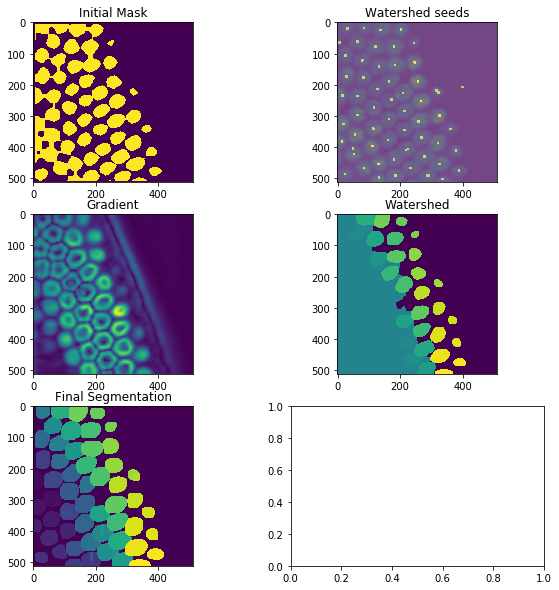

In [30]:
a3=segment_nuclei3D_4(bgsub[1,2],seed_window=(70,50,50), circularity_min=0.0, size_max=2e6, size_min=0,sigma1=2,sigma_grad=7,display=True)

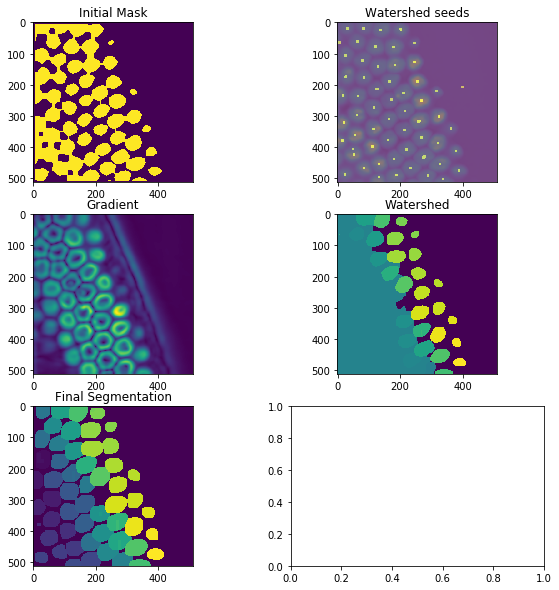

In [31]:
a3=segment_nuclei3D_4(bgsub[1,2],seed_window=(70,50,50), circularity_min=0.0, size_max=2e6, size_min=0,sigma1=4,sigma_grad=7,display=True)

In [ ]:
a3=segment_nuclei3D_4(bgsub[1,2],seed_window=(70,50,50), circularity_min=0.0, size_max=2e6, size_min=0,sigma1=5,sigma_grad=7,display=True)

I'm just not thrilled by the gradient. What about trying a different input filter, a difference-of-gaussians rather than just gaussians. Trying out dog filter:

In [40]:
a=dog_filter(bgsub[1,0],10,20)
b=gradient_nD(a)
viewer([a,b],'zxy')

/Users/MStadler/Bioinformatics/Projects/Zelda/Quarantine_analysis/bin/imagep.py:322: RuntimeWarning: invalid value encountered in sqrt
  gradient = np.sqrt(sumsq)


interactive(children=(Dropdown(description='Color', index=3, options=('magma', 'cividis', 'gray', 'viridis', '…

Looks pretty solid. Trying to update 3D segmentation function with dog filter

In [49]:
from skimage.filters.thresholding import threshold_li, threshold_otsu
from skimage.segmentation import flood_fill, watershed

def segment_nuclei3D_5(instack, sigma1=3, sigma_dog_small=10, sigma_dog_big=20, seed_window=(70,100,100),
                       erosion_length=10, dilation_length=10, size_min=1e4, 
                       size_max=7.5e5, circularity_min=0.2, display=False):
    """Segment nuclei from a 3D imaging stack
   
    Args:
        instack: ndarray
            3D image stack of dimensions [z, x, y].
        sigma1: int
            Sigma for initial Gaussian filter, for making initial mask
        sigma_grad: int
            Sigma for Gaussian filter used to make gradient for watershed
        seed_window: tuple of three ints
            Size in [z, x, y] for window for determining local maxes in distance
            transform. Generally want size to be ~ size of nuclei.
        erosion_length: int
            Size in x and y of structuring element for erosion of initial mask.
        dilation_length: int
            Size in x and y of structuring element for dilating objects after
            final segmentation.
        size_min: int
            Minimum size, in pixels, of objects to retain
        size_max: int
            Maximum size, in pixels, of objects to retain
        circularity_min: float
            Minimum circularity measure of objects to retain
    
    Returns:
        labelmask: ndarray
            Mask of same shape as input stack with nuclei segmented and labeled
    
    """
    # Normalize each Z-slice to mean intensity to account for uneven illumination.
    stack = zstack_normalize_mean(instack)
    # Apply gaussian filter.
    stack_smooth = ndi.filters.gaussian_filter(stack, sigma=sigma1)
    # Threshold, make binary mask, fill.
    t = threshold_otsu(stack_smooth)
    mask = np.where(stack_smooth >= t, 1, 0)
    mask = imfill(mask, (0,0,100))
    # Use morphological erosion to remove spurious connections between objects.
    mask = ndi.morphology.binary_erosion(mask, structure=np.ones((1, erosion_length, erosion_length)))
    # Perform distance transform of mask.
    dist = ndi.distance_transform_edt(mask)
    # Find local maxima for watershed seeds.
    seeds, _ = peak_local_max_nD(dist, size=seed_window)
    # Re-smooth, do gradient transform to get substrate for watershedding.
    dog = dog_filter(stack, sigma_dog_small, sigma_dog_big)
    grad = gradient_nD(dog)
    # Segment by watershed algorithm.
    ws = watershed(grad, seeds.astype(int))
    # Filter nuclei for size and circularity.
    labelmask = labelmask_filter_objsize(ws, size_min, size_max)
    labelmask = filter_labelmask(labelmask, object_circularity, circularity_min, 1000)
    # Lightly dilate labeled structures.
    labelmask = labelmask_apply_morphology(labelmask, 
            mfunc=ndi.morphology.binary_dilation, 
            struct=np.ones((1, dilation_length, dilation_length)), 
            expand_size=(1, dilation_length + 1, dilation_length + 1))
    
    if (display):
        middle_slice = int(stack.shape[0] / 2)
        fig, ax = plt.subplots(3,2, figsize=(10,10))
        # Display mask.
        ax[0][0].imshow(mask.max(axis=0))
        ax[0][0].set_title('Initial Mask')
        # Display watershed seeds.
        seeds_vis = ndi.morphology.binary_dilation(seeds, structure=np.ones((1,8,8)))
        ax[0][1].imshow(stack_smooth.max(axis=0), alpha=0.5)
        ax[0][1].imshow(seeds_vis.max(axis=0), alpha=0.5)
        ax[0][1].set_title('Watershed seeds')
        # Display gradient.
        ax[1][0].imshow(grad[middle_slice])
        ax[1][0].set_title('Gradient')
        # Display watershed output.
        ax[1][1].imshow(ws.max(axis=0))
        ax[1][1].set_title('Watershed')
        # Display final mask.
        ax[2][0].imshow(labelmask.max(axis=0))
        ax[2][0].set_title('Final Segmentation')
        
    return labelmask

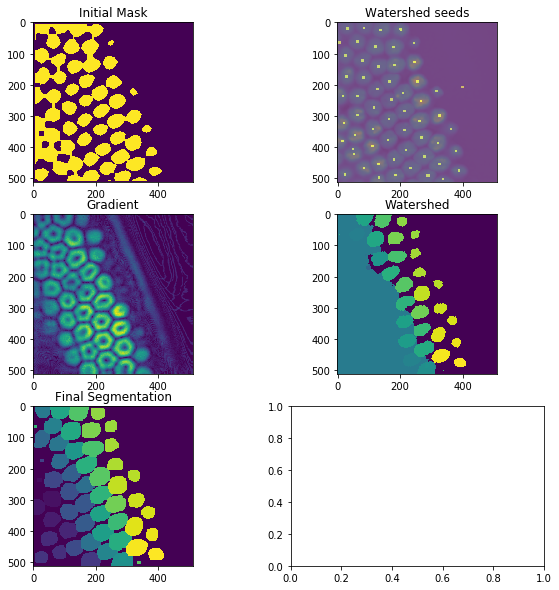

In [51]:
a=segment_nuclei3D_5(bgsub[1,2],seed_window=(70,50,50), circularity_min=0.0, size_max=2e6, size_min=0,sigma1=3,display=True)

In [7]:
test2 = lattice_segment_nuclei_5(bgsub, seed_window=(70,50,50), circularity_min=0.1, size_max=2e6, size_min=0)

/Users/MStadler/Bioinformatics/Projects/Zelda/Quarantine_analysis/bin/imagep.py:322: RuntimeWarning: invalid value encountered in sqrt
  gradient = np.sqrt(sumsq)
/Users/MStadler/Bioinformatics/Projects/Zelda/Quarantine_analysis/bin/imagep.py:781: RuntimeWarning: divide by zero encountered in double_scalars
  circularity = 4 * np.pi * area / (perimeter ** 2)


1
2
3


In [11]:
viewer(test2, 'tzxy')

interactive(children=(Dropdown(description='Color', index=9, options=('Greens', 'inferno', 'Reds', 'magma', 'p…

In [10]:
test3 = lattice_segment_nuclei_5(bgsub, seed_window=(70,50,50), circularity_min=0.1, size_max=2e6, size_min=0, erosion_length=5, dilation_length=5)

1
2
3


In [12]:
viewer(test3)

interactive(children=(Dropdown(description='Color', index=9, options=('Greens', 'inferno', 'Reds', 'magma', 'p…

In [15]:
mask = lattice_segment_nuclei_5(bgsub, seed_window=(70,50,50), circularity_min=0.1, size_max=7.5e5, size_min=0, erosion_length=5, dilation_length=10)

1
2
3


In [14]:
viewer(test4)

interactive(children=(Dropdown(description='Color', index=9, options=('Greens', 'inferno', 'Reds', 'magma', 'p…

OK, sidetracked by nuclear segmentation as always. Grr. Back to updating spots:

1. Spots can disappear for (multiple) frames, and it would be useful to not just toss anything that disappears for a frame.
2. I connected nuclei by looking for overlap. Because expected jump lengths for spots is larger than their diameter, I obviously can't do this.
3. I need to drag gaussian fit parameters along with the segmentation.
4. Spots are subject to the constraint that they must stay in the same nucleus.
5. In some experiments (diploids, but also potentially post-replication) we can have two spots in a nucleus.

Some solutions:

1. The simplest way to do this is probably to just assign spots explicitly to nuclei. Under the assumption of one spot per nuclues (see 5), a spot in the nucleus at a previous time point is the same spot. Relies on robust nuclear tracking and segmentation but that should be possible.
2. Assign a max jump length (in nm, will need conversions in axial and lateral dimensions)
3. In connecting function, build data structure to store frame-by-frame fit parameters, including dummy entries for frames where spot disappears.
4. Utilize nuclear mask to aid connections.
5. Not sure. One possibility is explicitly detecting 1 vs. 2 spots. The widths from the gaussian fits may do it. I think I'll proceed on the assumption of a single spot and try to handle multiple spots 


I'm going to ignore #5 for the time being. This will be harder to handle. I can knock out 1-4 though so I'll do that.

In [469]:
reload(imp);

In [470]:
ms2_0 = imp.segMS2_3dstack(stack[0,0])

In [471]:
ms2_0

{1: array([  0.        , 315.        ,   1.        , 348.8110525 ,
          1.16304688,   5.10883799,   9.        ,   7.95937739,
         34.64166901,  16.14661326]),
 2: array([ 15.        , 406.        ,  87.        , 120.53147584,
          7.99999998,   5.76002072,   2.97127543,  47.78919779,
         39.35834262,  42.12734129]),
 3: array([2.10000000e+01, 3.18000000e+02, 5.30000000e+01, 3.40603096e+02,
        3.53856332e-15, 3.63203524e-12, 9.00000000e+00, 7.05723655e+00,
        1.98634303e+01, 1.18038976e+01]),
 4: array([ 37.        , 354.        , 118.        , 213.65171896,
          2.55195009,   8.99999999,   8.99999981,  38.05398756,
         32.08331166, 171.07439357]),
 5: array([5.40000000e+01, 2.49000000e+02, 1.53000000e+02, 3.58837284e+02,
        1.33081095e-15, 3.89924309e-12, 9.00000000e+00, 6.98514002e+00,
        1.71576493e+01, 1.14538104e+01]),
 6: array([5.40000000e+01, 3.47000000e+02, 1.97000000e+02, 2.26995491e+02,
        2.40431496e+00, 8.04790947e+00, 

In [472]:
ms2_1 = imp.segMS2_3dstack(stack[0,1])

In [473]:
ms2_2 = segMS2_3dstack(stack[0,2])

In [ ]:
# Old functions I just want to keep somewheres.
# Retrieve dict of (z,x,y) coordinate tuple for all objects in mask.
def get_all_spot_coords(mask):
    coords = {}
    for n in np.unique(mask)[1:]:
        coords[n] = get_spot_coords(mask, n)
    return coords

# Retrieve (z,x,y) coordinate tuple for a one-pixel object in labelmask.
def get_spot_coords(mask, id_):
    coords = np.where(mask == id_)
    return (coords[0][0], coords[1][0], coords[2][0])

In [573]:
# Initialize labelstack and info with first frame.
#labelstack = np.expand_dims(s,0)
info = ms2_0.copy()
for n in info:
    info[n] = np.expand_dims(np.append([0], info[n]), 0)

In [1]:
def add_ms2_frame(spot_data, newframe_spotdata, nucmask, t, 
                  max_frame_gap=1, max_jump=10, scale_xy=1, scale_z=1):
    """Take a labelstack (4d stack of spots covering previous frames), info 
    (dict of location, time, and fit params for individual spots), and label
    mask and fit params for this frame. Assign objects in new frame to those
    from previous frames, add to the running objects."""
 
    def initialize_new_spot(new_spot_data, spot_data):
            new_id = max(spot_data.keys()) + 1
            spot_data[new_id] = np.expand_dims(new_spot_data, 0)

    # Determine squared Euclidean distance between two [z,x,y] points in real distance.
    def sq_euc_distance(coords1, coords2, scale_z=1, scale_xy=1):
        """Find the squared euclidean distance between two points"""
        z2 = ((coords2[0] - coords1[0]) * scale_z) ** 2
        x2 = ((coords2[1] - coords1[1]) * scale_xy) ** 2
        y2 = ((coords2[2] - coords1[2]) * scale_xy) ** 2
        sed = z2 + x2 + y2
        return sed
    
    # Make a list of coordinates for all spots in a frame
    def coord_list_t(spot_data, t):
        coord_list = []
        for spot_id in spot_data:
            this_spot_data = spot_data[spot_id]
            row = this_spot_data[this_spot_data[:,0] == t]
            if (len(row) > 0):
                row = list(row[0])
                spot_coords = [spot_id] + row[1:4]
                coord_list.append(spot_coords)
        return coord_list
            
    # For a point in a labelmask, find closest object and its distance from the point.
    def find_nearest_spot(this_coord, coord_list, scale_z, scale_xy):
        closest_sed = np.inf
        closest_spot = 0
        print(this_coord)
        for test_data in coord_list:
            test_spot_id = test_data[0]
            test_coords = (test_data[1:4])
            sed = sq_euc_distance(test_coords, this_coord, scale_z, scale_xy)
            if (sed < closest_sed):
                closest_sed = sed
                closest_spot = test_spot_id
                closest_spot_coords = test_coords
        return closest_spot, np.sqrt(closest_sed), closest_spot_coords

    def update_spot(this_spot_data, spot_data, scale_z, scale_xy, max_frame_gap, t):
        # Walk back one frame at a time within limit set by maximum gap, search for a nearest
        # spot that is within the maximum allowable jump.
        this_spot_coords = (this_spot_data[1:4])
        for t_lag in range(1, max_frame_gap + 2):
            if ((t - t_lag) >= 0):
                spot_coords_tlag = coord_list_t(spot_data, t - t_lag)
                nearest_spot_id, dist, nearest_spot_coords = find_nearest_spot(this_spot_coords, spot_coords_tlag, scale_z, scale_xy)
                if (dist <= max_jump):
                    # Check if there's already a spot added for this time.
                    existing = spot_data[nearest_spot_id][spot_data[nearest_spot_id][:,0] == t]
                    # If no existing, add this spot to the end of the data for connected spot
                    if (len(existing) == 0):
                        spot_data[nearest_spot_id] = np.append(spot_data[nearest_spot_id], [this_spot_data], axis=0)
                        return
                    # If there is an existing spot, if the current spot is closer to the previous-frame spot
                    # than the existing entry, replace it. Otherwise, continue looking in previous frames (if
                    # applicable) and eventually create new spot after for loop. I'm not sure this is the best
                    # behavior--may consider dumping out of for loop and creating new spot rather than looking
                    # to previous frames in this situation.
                    else:
                        existing_dist = np.sqrt(sq_euc_distance(nearest_spot_coords, existing[0,1:4], scale_z, scale_xy))
                        # If the the current spot is closer than 
                        if (dist < existing_dist):
                            row_index = np.where(spot_data[nearest_spot_id][:,0] == t)[0][0]
                            superseded_spot_data = spot_data[nearest_spot_id][row_index]
                            # Superseded spot from this frame gets bumped to be a new spot.
                            initialize_new_spot(superseded_spot_data, spot_data)
                            spot_data[nearest_spot_id][row_index] = this_spot_data
                            return

        # If no suitable spot was found in previous frames, make a new spot.
        initialize_new_spot(this_spot_data, spot_data)
        
    
    # Main
    spot_data = spot_data.copy()
    # Go through each spot in the new mask
    for this_spot_id in newframe_spotdata:
        this_spot_data = np.append([t], newframe_spotdata[this_spot_id])
        update_spot(this_spot_data, spot_data, scale_z, scale_xy, max_frame_gap, t)
    return spot_data   


def ms2_segment_stack(stack, channel, nucmask, seg_func=segMS2_3dstack, max_frame_gap=1, max_jump=10, 
                      scale_xy=1, scale_z=1, **kwargs):
    # Segment first frame.
    nframes = stack[channel].shape[0]
    spot_data = seg_func(stack[channel, 0], **kwargs)
    # Prepare spotdata by adding dimension.
    for n in spot_data:
        spot_data[n] = np.expand_dims(np.append([0], spot_data[n]), 0)
    # Segment and connect subsequent frames.
    for t in range(1, nframes):
        substack = stack[channel, t]
        print(t)
        frame_data = seg_func(substack, **kwargs)
        spot_data = add_ms2_frame(spot_data, frame_data, nucmask, t, max_frame_gap=max_frame_gap,
            max_jump=max_jump, scale_xy=scale_xy, scale_z=scale_z)
    return spot_data

NameError: name 'segMS2_3dstack' is not defined

In [2]:
b = stack[:,:,30:40]
a1=ms2_segment_stack(stack,0,[],imp.segMS2_3dstack)

NameError: name 'stack' is not defined

# 5-22: 
* Two spots can be added to the same previous spot. Fix this...
*

In [676]:
a1[8]

array([[0.00000000e+00, 5.60000000e+01, 2.22000000e+02, 1.20000000e+02,
        2.50421478e+02, 3.49304204e-01, 3.83427651e+00, 5.46845434e+00,
        1.66623687e+01, 1.57391504e+01, 1.56899042e+01],
       [1.00000000e+00, 6.00000000e+01, 2.26000000e+02, 1.17000000e+02,
        1.92285477e+02, 6.15714085e+00, 9.18727724e-15, 5.12226557e+00,
        2.71411183e+01, 2.26065180e+01, 2.82345748e+01],
       [2.00000000e+00, 5.80000000e+01, 2.23000000e+02, 1.17000000e+02,
        1.94650691e+02, 3.10106450e+00, 9.00000000e+00, 2.67484927e-10,
        1.01672908e+02, 3.05539216e+01, 1.59950316e+02],
       [3.00000000e+00, 5.40000000e+01, 2.22000000e+02, 1.16000000e+02,
        1.91334122e+02, 2.30966800e+00, 3.04867954e+00, 4.75356447e-01,
        1.83900131e+01, 1.96812575e+01, 4.69662823e+01]])

In [397]:
max_frame_gap=1
last_coords=[]
for frame in range(1, max_frame_gap + 2):
    last_coords.append(get_all_spot_coords(labelstack[-frame]))

In [565]:
def coord_list_frame(data, t):
    coord_list = []
    for spot_id in data:
        spotdata = data[spot_id]
        row = spotdata[spotdata[:,0] == t]
        if (len(row) > 0):
            row = list(row[0])
            spot_info = [spot_id] + row[1:4]
            coord_list.append(spot_info)
    return coord_list
coord_list_frame(info,0)

[[1, 0.0, 315.0, 1.0],
 [2, 15.0, 406.0, 87.0],
 [3, 21.0, 318.0, 53.0],
 [4, 37.0, 354.0, 118.0],
 [5, 54.0, 249.0, 153.0],
 [6, 54.0, 347.0, 197.0],
 [7, 55.0, 294.0, 157.0],
 [8, 56.0, 222.0, 120.0],
 [9, 61.0, 261.0, 101.0],
 [10, 68.0, 289.0, 219.0],
 [11, 89.0, 197.0, 188.0],
 [12, 98.0, 234.0, 214.0]]

In [555]:
a = info[1]
np.where(a[:,0] == 0)


(array([0]),)

In [197]:
a = {
    1: 'a',
    2: 'b',
    700: 'c'
}
b=a
b[4]= 'poop'
a[4]

'poop'

In [366]:
tup = (1,2,3)
np.append([0], [np.array([1,2,3]), np.ndarray([4,5,6])])


array([0, array([1, 2, 3]),
       array([[[0.00000000e+000, 5.45361207e-312, 5.45361240e-312,
         0.00000000e+000, 0.00000000e+000, 7.74860419e-304],
        [1.39612477e-309, 0.00000000e+000, 0.00000000e+000,
         7.74860419e-304, 1.39612477e-309, 0.00000000e+000],
        [0.00000000e+000, 7.74860419e-304, 5.45361240e-312,
         0.00000000e+000, 0.00000000e+000, 7.74860419e-304],
        [1.39612477e-309, 0.00000000e+000, 7.74860419e-304,
         7.74860419e-304, 7.74860419e-304, 8.32155212e-317],
        [7.74860419e-304, 7.74860419e-304, 7.74860419e-304,
         8.32155212e-317, 7.74860419e-304, 7.74860419e-304]],

       [[7.74860419e-304, 8.32155212e-317, 7.74860419e-304,
         7.74860419e-304, 7.74860419e-304, 8.32155212e-317],
        [7.74860419e-304, 7.74860419e-304, 7.74860419e-304,
         8.32155212e-317, 7.74860419e-304, 7.74860419e-304],
        [7.74860419e-304, 2.13031734e-314, 7.74860419e-304,
         7.74860419e-304, 7.74860419e-304, 1.39612477e-3

In [433]:
a=np.where(labelmask == 1)

In [438]:
a[1][0]

313

In [7]:
%history -g

 1/1:
import matplotlib.pyplot as plt
import numpy as np
import skimage.filters as filters
import stax
import vu
 3/1: tchzstack = czifile.imread('180817_dev1.czi')
 3/2:
import matplotlib.pyplot as plt
import numpy as np
import skimage.filters as filters
import stax
import vu
 4/1: import matplotlib.pyplot as plt
 4/2: import numpy as np
 4/3:
import numpy as np
import skimage.filters as filters
 4/4:
import numpy as np
import stax
import vu
 5/1: import matplotlib.pyplot as mpl
 6/1: import matplotlib.pyplot as mpl
 7/1: import matplotlib.pyplot as mpl
 7/2:
import matplotlib.pyplot as mpl
import numpy as np
 7/3:
import matplotlib.pyplot as mpl
import numpy as np
import stax
import vu
 7/4:
import matplotlib.pyplot as mpl
import numpy as np
import skimage.filters as filters
import stax
import vu
 7/5:
import czifile
import matplotlib.pyplot as mpl
import numpy as np
import skimage.filters as filters
import stax
import vu
 7/6: tchzstack = czifile.imread('180817_dev1.czi')
 7/7: tchz

38/2: stack = read_tiff_lattice('/Users/MStadler/Bioinformatics/Projects/Zelda/Quarantine_analysis/data/20180215_BcdEve_em1_mv2/', span=(10,1000))
38/3: stack = read_tiff_lattice('/Users/MStadler/Bioinformatics/Projects/Zelda/Quarantine_analysis/data/20180215_BcdEve_em1_mv2/', span=(30,40))
39/1:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi 
# from skimage import filters, measure, segmentation, transform, exposure, img_as_ubyte, feature, morphology
from skimage import filters, io
import sys

sys.path.append('/Users/MStadler/Bioinformatics/Projects/Zelda/Quarantine_analysis/bin')
from imagep import read_tiff_folder, read_tiff_lattice, viewer, viewer
39/2:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi 
# from skimage import filters, measure, segmentation, transform, exposure, img_as_ubyte, feature, morphology
from skimage import filters, io
import sys

sys.path.append('/Users/MStadler/Bioinformatics/Projects/Zel

64/6:
def segment_embryo(stack, channel=0, sigma=5, walkback = 50):
    """
    
    """
    def _make_mask(stack, channel, sigma, walkback):
        # Make a mean projection (on time axis) for desired channel. 
        im = stack[channel].mean(axis=0)
        # Smooth with gaussian kernel.
        im_smooth = ndi.filters.gaussian_filter(im, sigma=sigma)
        # Find threshold with minimum method.
        t = filters.threshold_minimum(im_smooth)
        # Make binary mask with threshold
        mask = np.where(im_smooth > t, im, 0)
        mask = mask.astype('bool')
        struc = np.ones((1,1, walkback))
        midpoint = int(walkback / 2)
        struc[0, 0, 0:midpoint] = 0
        mask = ndi.morphology.binary_fill_holes(mask, structure=np.ones((1,2,2)))
        mask = ndi.morphology.binary_erosion(mask, structure=struc)
        return mask
    
    def _apply_mask(stack, mask):
        stack3d[mask] = 0
        for index in np.ndindex(stack_e1m3.shape[:-3]):
            substack

85/32: viewer2(stack[1,0], 'zxy')
85/33:
def viewer(stack, order='tzxy'):
    """Interactive Jupyter notebook viewer for n-dimensional image stacks.
    
    Args:
        stack: ndarray
            n-dimensional image, last two dimensions must be x-y to display
        order: string
            String specifying order of image dimensions. Examples: 'ctzxy' 
            or 'tzxy'. Last two dimensions must be 'xy'.
            
    Returns: none
        
    Raises:
        ValueError: 
            If final two dimensions are not xy
        ValueError:
            If the number of dimensions in the order string does not match
            the dimensions of the stack
    """
    # Update the displayed image with inputs from widgets.
    def _update_view(order, **kwargs):
        indexes = []
        colmap = kwargs['colmap']
        min_ = kwargs['contrast'][0]
        max_ = kwargs['contrast'][1]
        
        # Unpack order variable into array.
        order_arr = [char for char in o

91/552:
import skimage as ski
############################################################################
def segment_nuclei3D_2(stack, sigma=5, dist_sigma=2, window_size=(70, 100, 100), closing_length=10):
    """Segment nuclei from a single 3D lattice stack.
    
    Details: Segments nuclei in lattice light sheet 3D image substack. Uses
    a gradient filter to find edges of nuclei, fills them, finds their 
    centers, and performs watershed segmentation. Resulting objects are 
    filtered for size and roundness and a 3D labelmask of nuclei is returned.
    
    Args:
        stack: 3D ndarray
            Image stack in order [z, x, y].
        sigma: int
            Sigma value to use for gaussian smoothing of original image.
        dist_sigma: int
            Sigma value to use for gaussian smoothing of distance transform
            of gradient.
        closing_length: int
            Side length of the structuring unit for morphological closing of 
            thresholded gr

121/55:
ax =qax(9)

#ax[0].imshow(red)
121/56:
def dog_filter(stack, sigma_big, sigma_small):
    return ndi.filters.gaussian_filter(stack, sigma=sigma_big) - ndi.filters.gaussian_filter(stack, sigma=sigma_small)

def log_filter(stack, sigma):
    gauss = ndi.filters.gaussian_filter(stack, sigma=sigma)
    log = ndi.filters.laplace(gauss)
    return log
def qax(n, ncol=4, figsize=(10,13)):
    nrow = int(np.ceil(n / ncol))
    fig, ax = plt.subplots(nrow, ncol, figsize=figsize)
    ax1d = np.ndarray(nrow * ncol)
    pos1d = 0
    for r in range(0, nrow):
        for c in range(0, ncol):
            print(str(r) + '___' + str(c) + '    ' + str(pos1d))
            ax1d[pos1d] = ax[nrow][ncol]
            pos1d = pos1d + 1
    return ax1d
121/57:
ax =qax(9)

#ax[0].imshow(red)
121/58:
def dog_filter(stack, sigma_big, sigma_small):
    return ndi.filters.gaussian_filter(stack, sigma=sigma_big) - ndi.filters.gaussian_filter(stack, sigma=sigma_small)

def log_filter(stack, sigma):
    gauss 

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

